# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/file/d/1aIZVjDHBR9smdcXXpaf3RnOJetmxQCJS/view?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab5.ipynb

[NbConvertApp] Converting notebook /content/Lab5.ipynb to html
[NbConvertApp] Writing 1288714 bytes to /content/Lab5.html


As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install torchtext==0.6

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
import torchtext

In [ ]:
torchtext.data.Field

torchtext.data.field.Field

In [ ]:
print(torch.__version__)
print(torchtext.__version__)

2.1.0+cu118
0.6.0


In [ ]:
!python --version


Python 3.10.12


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('SMSSpamCollection'):
  if line[0:3] == 'ham':
    print(line)
    break


ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [ ]:
for line in open('SMSSpamCollection'):
  if line[0:4] == 'spam':
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



label value for spam messgaes is spam

label value for non-spam messages is ham

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
ham_count = 0
for line in open('SMSSpamCollection'):
  if line[0:3] == 'ham':
    ham_count = ham_count+1

print("There are", ham_count, "non-spam messages in the data set")

There are 4827 non-spam messages in the data set


In [ ]:
spam_count = 0
for line in open('SMSSpamCollection'):
  if line[0:4] == 'spam':
    spam_count = spam_count+1

print("There are", spam_count, "spam messages in the data set")

There are 747 spam messages in the data set


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantage
*  there are only limited number of characters compared to  words, so require less memory
*  character-level RNN can model out of unseen vocabulary words because it can recognzie unfamiliar words, unlike word level RNN where the dictionary is fixed



Disadvantage
*   higher level of complexity because the model would be much larger when consider a word as multiple characters
*  can not recognize the context because characters it self does not have any meaning, unlike words, so hard to build context





### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection",
                                        "tsv",
                                        fields)

train, valid, test = dataset.split([0.6, 0.2, 0.2], stratified=True, random_state = np.random.seed(50))

In [ ]:
print(len(train))
print(len(valid))
print(len(test))

3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

If there are significantly more non-spam messages than spam messages, the model can become biased towards predicting as non-spam, ignoring the minority class.


In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

STOI is string -> index, give an string to STOI will return the index of the corresponding string

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fb006fc3c70>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'h': 13,
             '0': 14,
             'd': 15,
             '.': 16,
             'c': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             '2': 25,
             'b': 26,
             '8': 27,
             'T': 28,
             'k': 29,
             'v': 30,
             'E': 31,
             '5': 32,
             'C': 33,
             'S': 34,
             'I': 35,
             'O': 36,
             '7': 37,
             '4': 38,
             'N': 39,
             'x':

ITOS is index -> string, give an index to ITOS will return the corresponding string

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 'd',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 '2',
 'b',
 '8',
 'T',
 'k',
 'v',
 'E',
 '5',
 'C',
 'S',
 'I',
 'O',
 '7',
 '4',
 'N',
 'x',
 'A',
 '6',
 '3',
 'R',
 '!',
 ',',
 '9',
 'P',
 'U',
 'W',
 'M',
 'L',
 'H',
 'B',
 'D',
 'G',
 'F',
 'Y',
 '?',
 "'",
 '/',
 '£',
 '-',
 '&',
 ':',
 'z',
 'X',
 'V',
 'K',
 'j',
 ';',
 ')',
 'J',
 '+',
 '*',
 '"',
 'q',
 '(',
 'Q',
 '#',
 '>',
 '=',
 '@',
 'Z',
 'ü',
 '_',
 'Ü',
 '‘',
 '\x92',
 '$',
 '|',
 '<',
 '\x93',
 '¡',
 '…',
 '%',
 '’',
 '–',
 '“',
 '\x94',
 'é',
 '\t',
 '\n',
 '\\',
 '~',
 '\x91',
 '\x96',
 'É',
 'è',
 'ì',
 '—']

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

unk is the unknown token. If there is unknown character, it would be pad with unk.

pad is for ensuring all input have the same length. if not the same length, shorter ones will be pad with pad

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
count = 0
padindex = text_field.vocab.stoi["<pad>"]
print(padindex)
for batch in train_iter:
  maxlength = 0
  pad = 0
  if count == 10:
    break
  for sms in batch:
    if len(sms.sms[0]) > maxlength:
      maxlength = len(sms.sms[0])
    for char in sms.sms[0]:
      if char == padindex:
        pad+=1
  print("maximum length of input sequence in batch", count+1, "is", maxlength)
  print("pad count of the batch", count+1, "is", pad)
  count+=1

1
maximum length of input sequence in batch 1 is 134
pad count of the batch 1 is 15
maximum length of input sequence in batch 2 is 82
pad count of the batch 2 is 31
maximum length of input sequence in batch 3 is 80
pad count of the batch 3 is 47
maximum length of input sequence in batch 4 is 109
pad count of the batch 4 is 53
maximum length of input sequence in batch 5 is 21
pad count of the batch 5 is 105
maximum length of input sequence in batch 6 is 99
pad count of the batch 6 is 46
maximum length of input sequence in batch 7 is 141
pad count of the batch 7 is 14
maximum length of input sequence in batch 8 is 152
pad count of the batch 8 is 9
maximum length of input sequence in batch 9 is 55
pad count of the batch 9 is 22
maximum length of input sequence in batch 10 is 58
pad count of the batch 10 is 34


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input, hidden_size):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(input)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, train_data, val_data, train = False):
    if train:
      data = train_data
    else:
      data = val_data
    data_loader = torchtext.data.BucketIterator(data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    acc, total = 0, 0
    for sms, labels in data_loader:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        acc += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return acc / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    valid_loader = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

    iters, losses, train_acc, val_acc = [], [], [], []
    n=0
    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        iters.append(n)
        train_acc.append(get_accuracy(model, train, valid, train=True))
        val_acc.append(get_accuracy(model, train, valid, train = False))
        n+=1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
input_size = len(text_field.vocab.itos)


epoch number  1 accuracy:  0.5113579837506218
epoch number  2 accuracy:  0.5453490300116067
epoch number  3 accuracy:  0.5869673354335931
epoch number  4 accuracy:  0.6158182722599901
epoch number  5 accuracy:  0.643011109268778


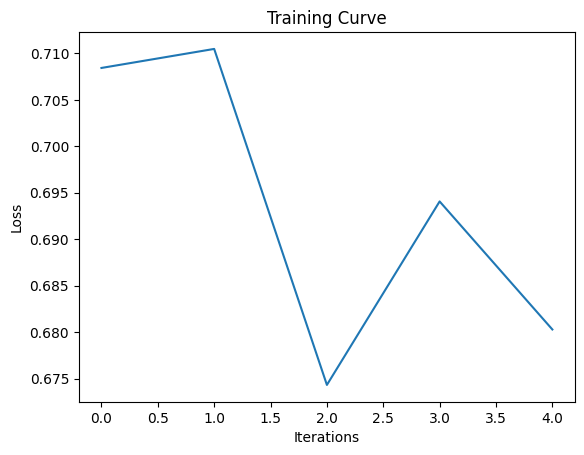

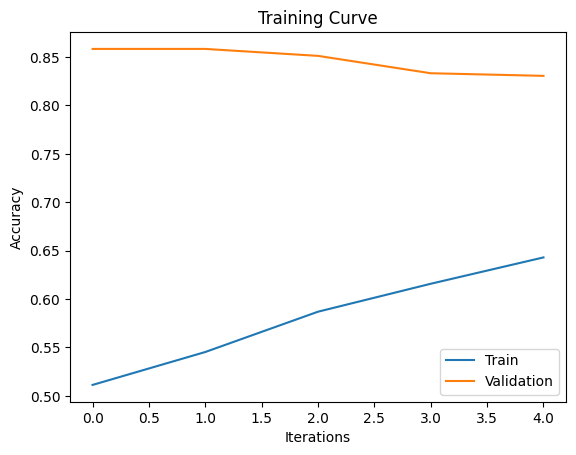

Final Training Accuracy: 0.643011109268778
Final Validation Accuracy: 0.8304932735426009


In [ ]:
model = RNN(input_size, 100)
train_rnn_network(model, train, valid, 5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

First start with random hyperparameter, I am trying with default learning rate and 30 epoch

epoch number  1 accuracy:  0.5531420991543691
epoch number  2 accuracy:  0.5924390648317028
epoch number  3 accuracy:  0.6173105620958381
epoch number  4 accuracy:  0.6382026197977119
epoch number  5 accuracy:  0.65809981760902
epoch number  6 accuracy:  0.6804841651467418
epoch number  7 accuracy:  0.6988890731222019
epoch number  8 accuracy:  0.72243409053225
epoch number  9 accuracy:  0.7522798872492124
epoch number  10 accuracy:  0.7726745150058033
epoch number  11 accuracy:  0.817111590117725
epoch number  12 accuracy:  0.8842646327308904
epoch number  13 accuracy:  0.9063173603050904
epoch number  14 accuracy:  0.8973636212900017
epoch number  15 accuracy:  0.8322002984579672
epoch number  16 accuracy:  0.9175924390648317
epoch number  17 accuracy:  0.918918918918919
epoch number  18 accuracy:  0.918753108937158
epoch number  19 accuracy:  0.930691427623943
epoch number  20 accuracy:  0.9275410379704858
epoch number  21 accuracy:  0.9267119880616813
epoch number  22 accuracy:  0.

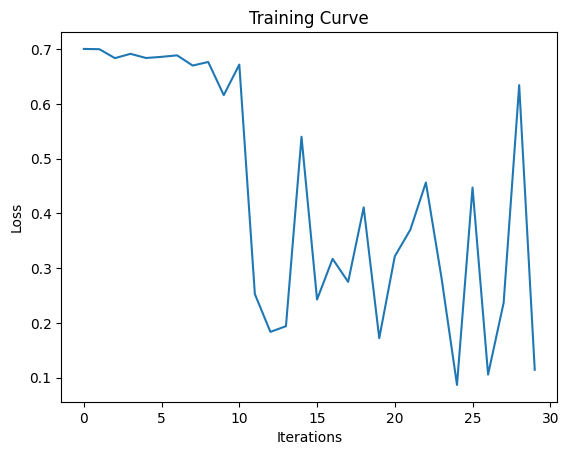

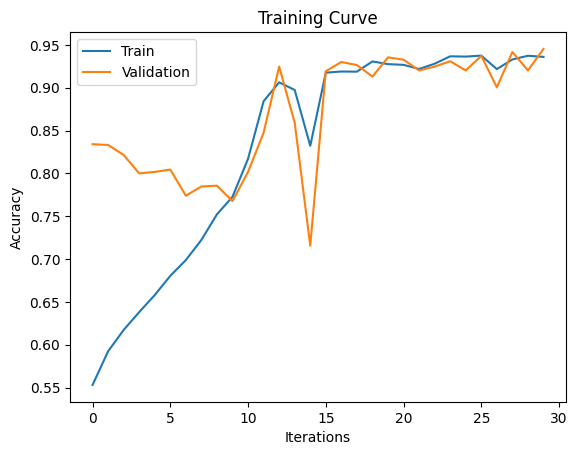

Final Training Accuracy: 0.9359973470402918
Final Validation Accuracy: 0.9452914798206278


In [ ]:
model = RNN(input_size, 100)
train_rnn_network(model, train, valid, 30)

because the curve does not seem to overfit yet, try with bigger learning rate to force convergence

epoch number  1 accuracy:  0.6829713148731553
epoch number  2 accuracy:  0.9112916597579174
epoch number  3 accuracy:  0.9227325484994197
epoch number  4 accuracy:  0.9260487481346377
epoch number  5 accuracy:  0.558282208588957
epoch number  6 accuracy:  0.9364947769855745
epoch number  7 accuracy:  0.9144420494113745
epoch number  8 accuracy:  0.9081412701044603
epoch number  9 accuracy:  0.9162659592107445
epoch number  10 accuracy:  0.9459459459459459
epoch number  11 accuracy:  0.9338418172774001
epoch number  12 accuracy:  0.9151052893384182
epoch number  13 accuracy:  0.9059857403415685
epoch number  14 accuracy:  0.6461614989222351
epoch number  15 accuracy:  0.82904990880451
epoch number  16 accuracy:  0.818769689935334
epoch number  17 accuracy:  0.9529099651799038
epoch number  18 accuracy:  0.9522467252528602
epoch number  19 accuracy:  0.9552313049245564
epoch number  20 accuracy:  0.9593765544685791
epoch number  21 accuracy:  0.7839495937655447
epoch number  22 accuracy:

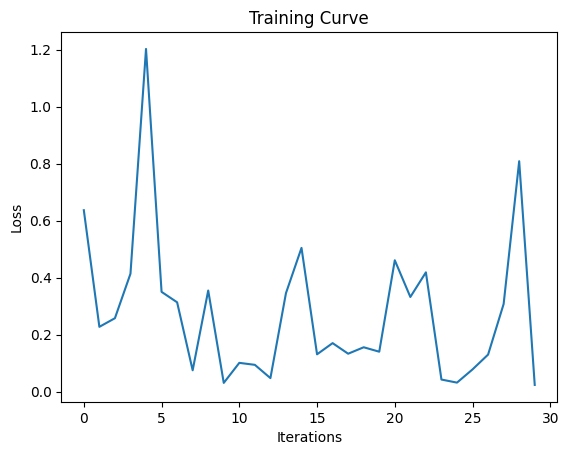

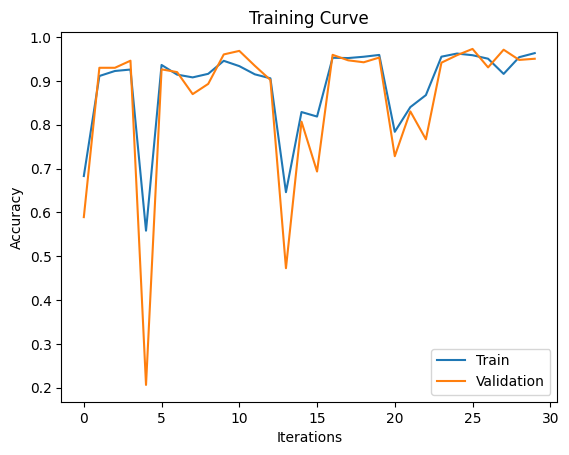

Final Training Accuracy: 0.9635218040126016
Final Validation Accuracy: 0.9506726457399103


In [ ]:
model = RNN(input_size, 100)
train_rnn_network(model, train, valid, 30, learning_rate = 0.0001)

very unstable graph, try lowering the learning rate and decreasing the number of epoch

epoch number  1 accuracy:  0.48250704692422486
epoch number  2 accuracy:  0.4818438069971812
epoch number  3 accuracy:  0.48250704692422486
epoch number  4 accuracy:  0.4864864864864865
epoch number  5 accuracy:  0.4878129663405737
epoch number  6 accuracy:  0.4888078262311391
epoch number  7 accuracy:  0.49427955562924886
epoch number  8 accuracy:  0.4937821256839662
epoch number  9 accuracy:  0.4967667053556624
epoch number  10 accuracy:  0.49776156524622783
epoch number  11 accuracy:  0.49958547504559775
epoch number  12 accuracy:  0.4992538550820759
epoch number  13 accuracy:  0.49875642513679325
epoch number  14 accuracy:  0.5000829049908805
epoch number  15 accuracy:  0.5010777648814458


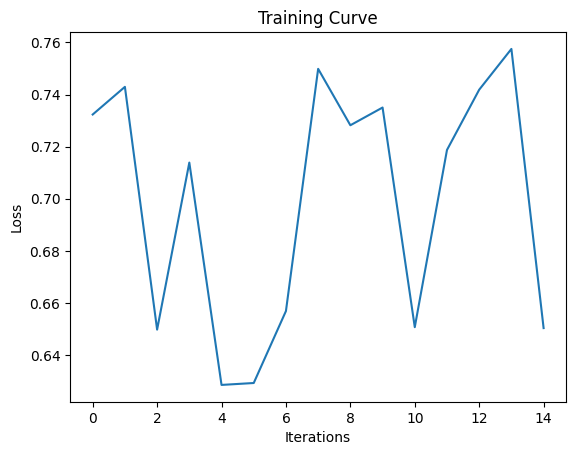

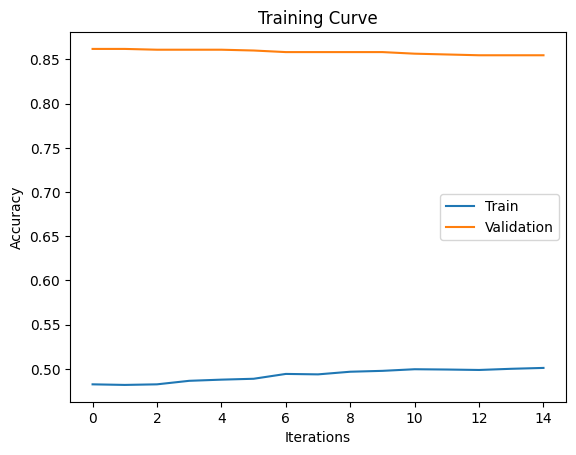

Final Training Accuracy: 0.5010777648814458
Final Validation Accuracy: 0.8547085201793722


In [ ]:
model = RNN(input_size, 100)
train_rnn_network(model, train, valid, 15, learning_rate = 0.000001)

the learning rate is too small so it is not decreasing much for loss. try tunning hidden layer size and batch size to make the model more complex and make the model converge faster by bigger batch size. The number of hidden layer is increased to 150 and the batch size is increased to 64.

In [ ]:
import matplotlib.pyplot as plt
def train_new_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torchtext.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    valid_loader = torchtext.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    iters, losses, train_acc, val_acc = [], [], [], []
    n=0
    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        iters.append(n)
        train_acc.append(get_new_accuracy(model, train, valid, train=True))
        val_acc.append(get_new_accuracy(model, train, valid, train = False))
        n+=1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def get_new_accuracy(model, train_data, val_data, train = False):
    if train:
      data = train_data
    else:
      data = val_data
    data_loader = torchtext.data.BucketIterator(data,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    acc, total = 0, 0
    for sms, labels in data_loader:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        acc += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return acc / total

epoch number  1 accuracy:  0.5096998839330128
epoch number  2 accuracy:  0.5286022218537556
epoch number  3 accuracy:  0.546509699883933
epoch number  4 accuracy:  0.5680649975128502
epoch number  5 accuracy:  0.5790084563090698
epoch number  6 accuracy:  0.5970817443210081
epoch number  7 accuracy:  0.612502072624772
epoch number  8 accuracy:  0.6121704526612503
epoch number  9 accuracy:  0.6314044105455149
epoch number  10 accuracy:  0.6357154700712982
epoch number  11 accuracy:  0.6532913281379539
epoch number  12 accuracy:  0.6647322168794562
epoch number  13 accuracy:  0.6796551152379373
epoch number  14 accuracy:  0.6851268446360471
epoch number  15 accuracy:  0.6932515337423313
epoch number  16 accuracy:  0.6995523130492456
epoch number  17 accuracy:  0.74266290830708
epoch number  18 accuracy:  0.7504559774498425
epoch number  19 accuracy:  0.8050074614491792
epoch number  20 accuracy:  0.8555795058862543
epoch number  21 accuracy:  0.8930525617642182
epoch number  22 accuracy:

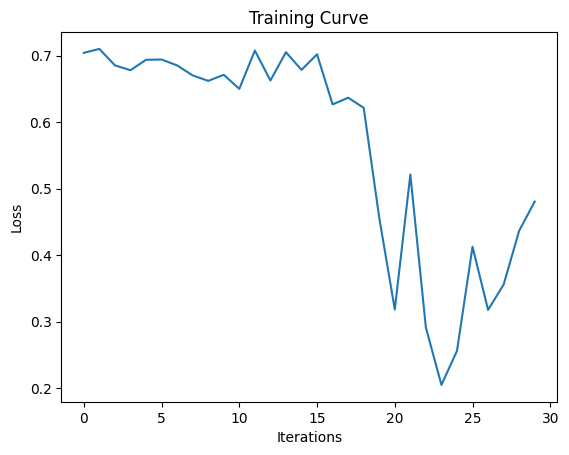

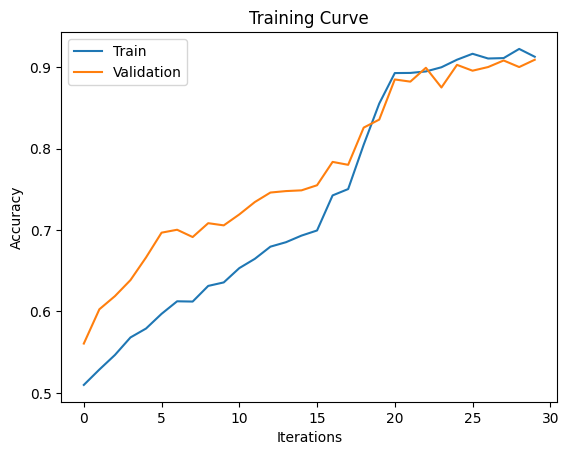

Final Training Accuracy: 0.9131155695572873
Final Validation Accuracy: 0.9094170403587444


In [ ]:
model = RNN(input_size, 150)
train_new_rnn_network(model, train, valid, 30)

From loss, it is very unstable, maybe should not try to tune batch size and try with the samller batch size. try just to tune hidden layer size and do not change batch size

epoch number  1 accuracy:  0.500746144917924
epoch number  2 accuracy:  0.5335765213065826
epoch number  3 accuracy:  0.5979107942298126
epoch number  4 accuracy:  0.6746808157851103
epoch number  5 accuracy:  0.7020394627756591
epoch number  6 accuracy:  0.7161333112253357
epoch number  7 accuracy:  0.7028685126844636
epoch number  8 accuracy:  0.7114906317360306
epoch number  9 accuracy:  0.7010446028850937
epoch number  10 accuracy:  0.8310396285856408
epoch number  11 accuracy:  0.8935499917095009
epoch number  12 accuracy:  0.9064831702868512
epoch number  13 accuracy:  0.9215718786270933
epoch number  14 accuracy:  0.9247222682805505
epoch number  15 accuracy:  0.9245564582987896
epoch number  16 accuracy:  0.927209418006964
epoch number  17 accuracy:  0.9278726579340076
epoch number  18 accuracy:  0.9336760072956392
epoch number  19 accuracy:  0.9330127673685956
epoch number  20 accuracy:  0.9333443873321174
epoch number  21 accuracy:  0.9346708671862046
epoch number  22 accurac

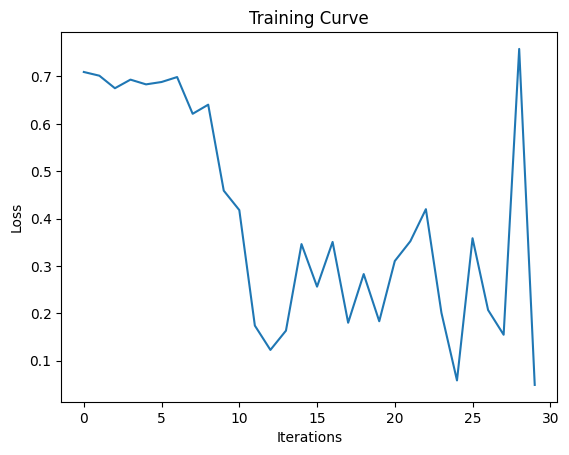

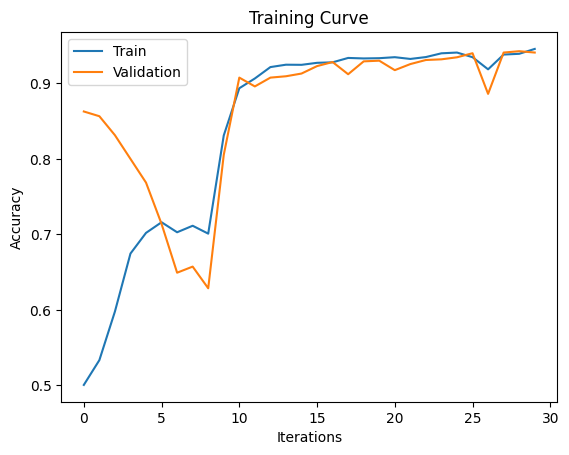

Final Training Accuracy: 0.9456143259824241
Final Validation Accuracy: 0.9408071748878923


In [ ]:
model = RNN(input_size, 150)
train_rnn_network(model, train, valid, 30, learning_rate = 0.00001)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
import matplotlib.pyplot as plt
def train_save_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    valid_loader = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    iters, losses, train_acc, val_acc = [], [], [], []
    n=0
    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        iters.append(n)
        train_acc.append(get_accuracy(model, train, valid, train=True))
        val_acc.append(get_accuracy(model, train, valid, train = False))
        n+=1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])
        model_path = get_model_name(model.name, learning_rate, num_epochs)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

epoch number  1 accuracy:  0.45199801028021885
epoch number  2 accuracy:  0.4859890565412038
epoch number  3 accuracy:  0.5153374233128835
epoch number  4 accuracy:  0.5320842314707346
epoch number  5 accuracy:  0.5629248880782624
epoch number  6 accuracy:  0.6270933510197314
epoch number  7 accuracy:  0.6506383684297795
epoch number  8 accuracy:  0.6833029348366771
epoch number  9 accuracy:  0.700547172939811
epoch number  10 accuracy:  0.7027027027027027
epoch number  11 accuracy:  0.7169623611341402
epoch number  12 accuracy:  0.7378544188360139
epoch number  13 accuracy:  0.7532747471397778
epoch number  14 accuracy:  0.7914110429447853
epoch number  15 accuracy:  0.8781296634057371
epoch number  16 accuracy:  0.8908970320013265
epoch number  17 accuracy:  0.8990217211076107
epoch number  18 accuracy:  0.8874150223843476
epoch number  19 accuracy:  0.8902337920742829
epoch number  20 accuracy:  0.9073122201956558
epoch number  21 accuracy:  0.9101309898855912
epoch number  22 accur

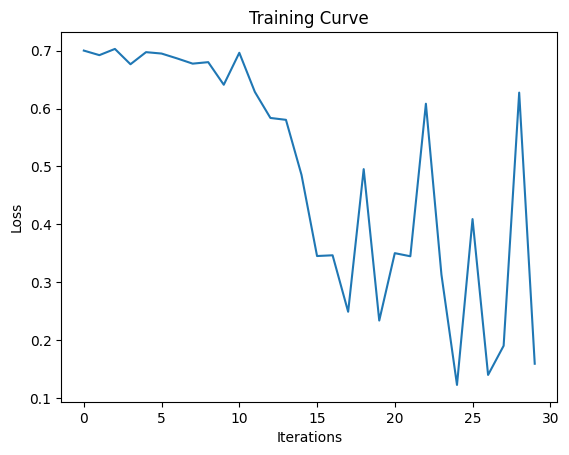

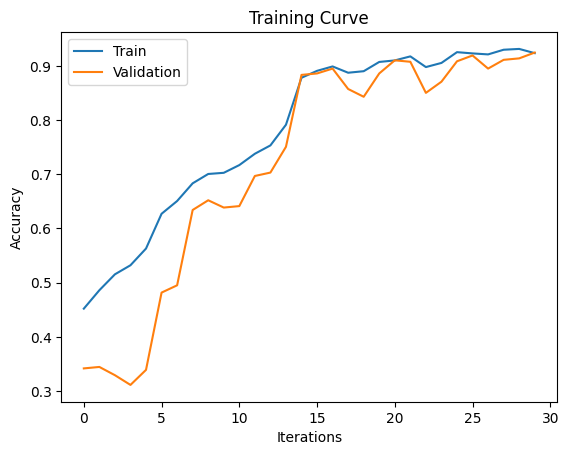

Final Training Accuracy: 0.9235615984082242
Final Validation Accuracy: 0.9246636771300448


In [ ]:
model = RNN(input_size, 100)
train_save_rnn_network(model, train, valid, 30)

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)


In [ ]:
model = RNN(input_size, 100)
model_path = get_model_name(model.name, learning_rate=1e-5, epoch=30)
state = torch.load(model_path)
model.load_state_dict(state)
valid_spam_loader = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
valid_nospam_loader = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_positive = 1 - get_accuracy(model, valid_nospam, valid_nospam)
false_negative = 1 - get_accuracy(model, valid_spam, valid_spam)
print("false_positive rate = ", false_positive*100, "%")
print("false_negative rate = ", false_negative*100,"%")


false_positive rate =  5.492227979274611 %
false_negative rate =  39.33333333333333 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

false positive: classify non-spam as spam. which would result in blocking of important information

false negative: classify span as non-spam, which means spam messages will still be received.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
model = RNN(input_size, 100)
model_path = get_model_name(model.name, learning_rate=1e-5, epoch=30)
state = torch.load(model_path)
model.load_state_dict(state)
test_loader = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
accuracy = get_accuracy(model, test, test)

In [ ]:
print("test accuracy:", accuracy)

test accuracy: 0.9443447037701975


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

In [ ]:
model = RNN(input_size, 100)
model_path = get_model_name(model.name, learning_rate=1e-5, epoch=30)
state = torch.load(model_path)
model.load_state_dict(state)
test_spam_loader = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
test_nospam_loader = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_positive = 1 - get_accuracy(model, test_nospam, test_nospam)
false_negative = 1 - get_accuracy(model, test_spam, test_spam)
print("false_positive rate = ", false_positive*100, "%")
print("false_negative rate = ", false_negative*100,"%")

false_positive rate =  3.83419689119171 %
false_negative rate =  30.87248322147651 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
model = RNN(input_size, 100)
model_path = get_model_name(model.name, learning_rate=1e-5, epoch=30)
state = torch.load(model_path)
model.load_state_dict(state)
msg = "machine learning is sooo cool!"
stoi = []
for i in msg:
  stoi.append(text_field.vocab.stoi[i])
print(stoi)
toTensor = torch.LongTensor([stoi])
result = model(toTensor)
pred = result.max(1, keepdim=True)[1]
print("the probability that is spam is", pred[0][0].item())



[18, 6, 17, 13, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 17, 4, 4, 11, 45]
the probability that is spam is 0


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think it is not difficult to reach optimum accuracy but there would still be false positive and false negative. Since I think the risk of having false positive is greater than having false negative because important information would be bloacked. we should try working on getting rid of false positives. it would be hard to get rid of the false positivies. I think it is something that should be worked on in the future.

A simple baseline model would be finding the frequent words in a spam message and detect all messages that have these frequent words as spam and test towards it.